# Численный рассчет температурных волн 
## На основе статьи А. А. Самарского и И. М. Соболя

Рассматривается квазилинейное уравнение теплопроводности

$$\displaystyle \frac{\partial \varphi(u)}{\partial t} = \sum_{\alpha = 1}^p \frac{\partial}{\partial x_\alpha} \left( K_\alpha(u) \frac{\partial u}{\partial x_\alpha}\right),\ K_\alpha(u) = \varkappa_\alpha u^{\sigma_\alpha},\ \sigma_\alpha \geqslant 1,\ \varkappa_\alpha > 0$$

## Одномерный случай $(p = 1)$

Рассмотрим уравнение

$$ \frac{\partial \varphi(u)}{\partial t} = \frac{\partial}{\partial x} \left[K(u) \frac{\partial u}{\partial x}\right]$$

$  K(0) = \varphi(0) = 0 $; $K(u) > 0,\ \varphi^{\prime}(u) > 0$ при $u > 0$; $\displaystyle \lim_{ u \to 0}\left[K(u) /\varphi^{\prime}(u) \right] = 0$

Будем рассматривать задачу с граничными условиями I рода

$$ u(t, 0) = \mu_l(t),\ \ u(t, l) = \mu_r(t) $$

Заменим уравнение однородной разностной схемой с опережением:

$$\varphi(v_i) - \varphi(\check{v_i}) = A_{i+1}(v_{i+1}-v_i) - A_i(v_i - v_{i-1}), \ i=\overline{1, N-1}$$

$$A_i = \frac{\tau}{h^2}K\left(\frac{v_{i-1} + v_i}{2} \right),\ i=\overline{1, N}$$

Символ $\check{v_i}$ — значение сеточной фукнции на шаге $j$ по времени, а $v_i$ — на шаге $j+1$. 

Предполагается равномерная сетка: $x_i = ih,\ 0 \leqslant i \leqslant N; \ t^j = j\tau$.

На каждом шаге по времени будем решать имеющуюся систему уравнений методом итераций. Обозначим номер итерации за $s$:

$$ \varphi \stackrel{(s+1)}{(v_i)} = \varphi \stackrel{(s)}{(v_i)} + \stackrel{(s+1)}{(v_i} - \stackrel{(s)}{v_i})\varphi^\prime \stackrel{(s)}{(v_i)}$$

Далее индексы $(s)$ для краткости опускаются.

$$ A_{i+1} \stackrel{(s+1)}{v_{i+1}} - (A_{i+1} + A_i + B_i)\stackrel{(s+1)}{v_i} + A_i\stackrel{(s+1)}{v_{i-1}} + F_i = 0 $$

$$ B_i = \varphi^\prime(v_i), \ \ F_i = \varphi(\check{v_i}) - \varphi(v_i) + v_iB_i  $$

Воспользуемся методом прогонки:

$$\alpha_1 = 0; \ \ \alpha_{i + 1} = \frac{A_{i+1}}{A_{i+1} + A_i(1-\alpha_i) + B_i}, \ \ i = \overline{1, N-1}$$
$$ \beta_1 = v_0; \ \ \beta_{i+1} = \frac{A_i\beta_i + F_i}{A_{i+1} + A_i(1-\alpha_i) + B_i}, \ \ i = \overline{1,N-1}$$
$$\stackrel{(s+1)}{v_N} = v_N; \ \ \stackrel{(s+1)}{v_i} = \alpha_{i+1}\stackrel{(s+1)}{v_{i+1}} + \beta_{i+1}, \ \ i = \overline{N-1, 1}$$
$$\stackrel{(0)}{v_i} = \check{v_i}, \ \ v_0 = \mu_l(j\tau), \ \ v_N = \mu_r(j\tau)$$

Условие окончания итераций:

$$ \max_{1 \leqslant i \leqslant N-1} \Big| \stackrel{(s+1)}{v_i} - \stackrel{(s)}{v_i} \Big| < \varepsilon $$


Реализуем функцию, делающую один шаг по времени (один проход итерационного метода).

In [74]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [75]:
def step_one_dim(u_start, h, tau, K, epsilon = 1e-3):
    '''
    Функция, делающая один шаг по времени (одномерная задача)
    Внутри нет явной зависимости от t, потому что она должна быть включена в u, переданный в функцию 
    Нулевая итерация - это значения с предыдущего шага + граничные условия на новом шаге на слева и справа
    '''
    N = u_start.size - 1 # размер массива x от 0 до Nh включительно N+1
    u_prev = u_start # исходный массив будет изменен!
    u_new = np.zeros_like(u_prev)
    alpha = np.zeros(N)
    beta = np.zeros(N)
    converged = False

    while not converged:
        A = tau / h ** 2 * K((u_prev[:-1] + u_prev[1:]) / 2) 
        # тут пока сделан случай phi(u) = u, поэтому B и F имеют очень простой вид
        B = np.ones(N - 1)
        F = u_start[1:-1]
        alpha[0] = 0
        beta[0] = u_prev[0]
        for i in range(0, N - 1): 
            alpha[i + 1] = A[i + 1] / (A[i + 1] + A[i] * (1 - alpha[i]) + B[i])
            beta[i + 1] = (A[i] * beta[i] + F[i]) / (A[i + 1] + A[i] * (1 - alpha[i]) + B[i])
        u_new[-1] = u_prev[-1]
        u_new[0] = u_prev[0]
        for i in range(N - 1, 0, -1):
            u_new[i] = alpha[i] * u_new[i + 1] + beta[i]
        if (np.max(np.abs(u_new - u_prev))) < epsilon:
            converged = True
        u_prev = u_new

    return u_prev

In [76]:
def solve_one_dim(u_start, h, tau, t_end, K, mu_l, mu_r, epsilon=1e-3):
    N_t = int(t_end / tau) + 1 # tau надо округлить так, чтобы достичь t_end
    tau = t_end / (N_t - 1)
    u = u_start.copy()

    for j in range(1, N_t + 1):
        u[0] = mu_l(j * tau)
        u[-1] = mu_r(j * tau)
        u = step_one_dim(u, h, tau, K, epsilon)

    return u

## Пример 1. Волна, распространяющаяся с постоянной скоростью

Рассмотрим аналитическое решение уравнения

$$ \frac{\partial u}{\partial t} = \frac{\partial}{\partial x}\left(\varkappa_0 u^\sigma \frac{\partial u}{\partial x} \right)$$

Оно представляет собой бегущую волну:

$$ 
u(t, x) = 
 \begin{cases}
   \left[\sigma c \varkappa_0 (ct + x_1 - x) \right]^{1/\sigma} & x \leqslant x_1 + ct\\
   0 & x \geqslant x_1 + ct
 \end{cases} 
 $$

 Возьмем $\sigma = 2,\ \varkappa_0 = 0.5,\ c = 5,\ x_1 = 0$

 За начальное условие выберем значение функции при $t_0 = 0.1$

 Краевые условия:  $u(t, 0) = 10 \sqrt{t}, \ \  u(t, x_N) = 0$

In [77]:
kappa_0 = 0.5
sigma = 2
c = 5
x_1 = 0
t_0 = 0.1

def u(x, t):
    return ((sigma * c / kappa_0 * (c * t + x_1 - x)) * np.heaviside(x_1 + c*t - x, 0)) ** (1 / sigma)

def mu_l(t):
    return 10 * np.sqrt(t + t_0)

def mu_r(t):
    return 0

def K(u):
    return kappa_0 * u ** sigma

N = 50
x = np.linspace(0, 1, N + 1)
h = 1 / N
tau =  1e-4

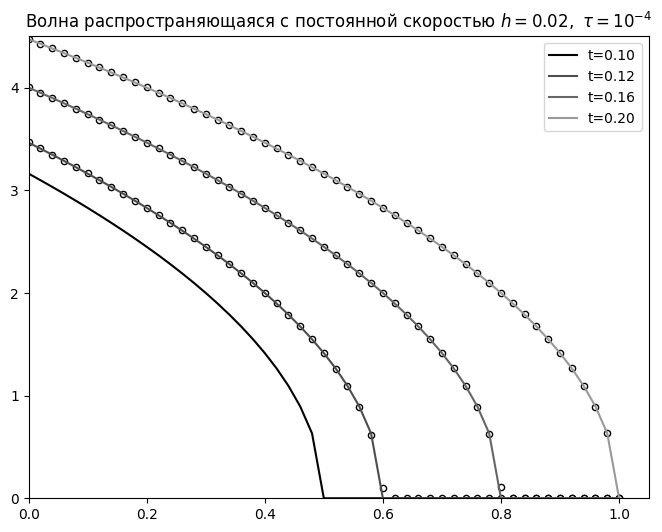

In [96]:
plt.figure(figsize=(8, 6))
plt.plot(x, u(x, t_0), color='0', label='t=0.10')
plt.plot(x, u(x, 0.12), color='0.3', label='t=0.12')
plt.plot(x, u(x, 0.16), color='0.4', label='t=0.16')
plt.plot(x, u(x, 0.20), color='0.6', label='t=0.20')

plt.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.12 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)
plt.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.16 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)
plt.scatter(x, solve_one_dim(u(x, t_0), h, tau, 0.2 - t_0, K, mu_l, mu_r), c='1', edgecolors='0', s=20)

plt.ylim(0, 4.5)
plt.yticks(range(0, 5))
plt.xlim(0, 1.05)
plt.legend()
plt.title("Волна распространяющаяся с постоянной скоростью $h = 0.02, \\ \\tau = 10^{-4}$")
plt.show()